In [484]:
import sys
import importlib
from tqdm import tqdm, trange
sys.path.append("../src")

import pseudobulk
importlib.reload(pseudobulk)
import models
importlib.reload(models)
import utils
importlib.reload(utils)

<module 'utils' from '/home/jhaberbe/Projects/Personal/bulk-deconvolution/notebook/../src/utils.py'>

In [464]:
import anndata as ad
import pandas as pd
import numpy as np
from scipy import sparse

def collapse_duplicate_var(adata: ad.AnnData) -> ad.AnnData:
    """
    Collapse duplicate var.index entries in an AnnData object by summing across columns (features),
    in both `X` and all matrices in `layers`. Returns a new AnnData object with unique var.index.
    """
    var_idx = adata.var.index

    # Get unique gene names and mapping
    grouped = pd.Series(np.arange(len(var_idx)), index=var_idx)
    unique_genes = grouped.groupby(level=0).apply(list)

    # Initialize containers for new matrices
    def collapse_matrix(mat):
        if sparse.issparse(mat):
            collapsed = sparse.hstack([
                mat[:, idxs].sum(axis=1) for idxs in unique_genes
            ]).tocsr()
        else:
            collapsed = np.stack([
                mat[:, idxs].sum(axis=1) for idxs in unique_genes
            ], axis=1)
        return collapsed

    # Collapse X
    X_collapsed = collapse_matrix(adata.X)

    # Collapse layers
    layers_collapsed = {}
    for key, mat in adata.layers.items():
        layers_collapsed[key] = collapse_matrix(mat)

    # Create new var dataframe
    var_new = adata.var.groupby(var_idx).first().loc[unique_genes.index]
    var_new.index.name = None  # remove name if present

    # Create new AnnData
    new_adata = ad.AnnData(
        X=X_collapsed,
        obs=adata.obs.copy(),
        var=var_new,
        layers=layers_collapsed,
        uns=adata.uns.copy(),
        obsm=adata.obsm.copy(),
        # varm=adata.varm.copy(), # skipping for now
        obsp=adata.obsp.copy(),
        varp=adata.varp.copy()
    )

    return new_adata


In [451]:
import scanpy as sc

pbulk = sc.read_h5ad(
    "/home/jhaberbe/Projects/Personal/bulk-deconvolution/data/pbulk.h5ad"
)

In [452]:
import pandas as pd
from collections import defaultdict

# If you have a GTF file:
gtf = pd.read_csv("/home/jhaberbe/Projects/Personal/bulk-deconvolution/data/gencode.v44.annotation.gtf", sep="\t", comment="#", header=None)
gtf_genes = gtf[gtf[2] == "gene"]
gtf_genes["gene_id"] = gtf_genes[8].str.extract('gene_id "([^"]+)"')
gtf_genes["gene_name"] = gtf_genes[8].str.extract('gene_name "([^"]+)"')
ensg_to_name = gtf_genes[["gene_id", "gene_name"]]
ensg_to_name["gene_id"] = ensg_to_name.gene_id.str.split(".").apply(lambda x: x[0])
ensg_to_name_mapping = defaultdict(str)
ensg_to_name_mapping.update(ensg_to_name.set_index("gene_id").to_dict()["gene_name"])

/tmp/ipykernel_1527556/2467798875.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gtf_genes["gene_id"] = gtf_genes[8].str.extract('gene_id "([^"]+)"')
/tmp/ipykernel_1527556/2467798875.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gtf_genes["gene_name"] = gtf_genes[8].str.extract('gene_name "([^"]+)"')
/tmp/ipykernel_1527556/2467798875.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [453]:
pbulk.var["names"] = [ensg_to_name_mapping[x] for x in pbulk.var.index]
pbulk = pbulk[:, pbulk.var["names"].ne("") & ~pbulk.var["names"].isin(pbulk.var["names"].value_counts()[pbulk.var.names.value_counts() > 1])]
pbulk.var = pbulk.var.set_index("names")
pbulk

AnnData object with n_obs × n_vars = 10000 × 37038
    obs: 'astrocyte', 'endothelial cell', 'ependymal cell', 'fibroblast', 'microglial cell', 'mural cell', 'neuron', 'oligodendrocyte'
    layers: 'astrocyte', 'endothelial cell', 'ependymal cell', 'fibroblast', 'microglial cell', 'mural cell', 'neuron', 'oligodendrocyte'

In [456]:
pbulk = collapse_duplicate_var(pbulk)

In [460]:
sc.pp.highly_variable_genes(pbulk, subset=False, flavor="seurat_v3")

# We load the bulk data to align to.

In [463]:
bulk_scanvi

AnnData object with n_obs × n_vars = 3317 × 63140
    obs: 'brain_number', 'brain_id', 'brain_region', 'well_id', 'brain_region_encoding', 'BrNum', 'AgeDeath', 'Race', 'Sex', 'Education', 'PMI', 'Manner of Death', 'Cause of Death', 'BMI', 'Handedness', 'Diagnoses', 'Medical Diagnoses', 'Other Medical Dx Comments', 'Tox Results Summary', 'Smoking TOD (NOK)', 'Age Onset Smoke', 'Age Offset Smoke', 'Last PPD', 'Last Medications', 'Lifetime Anticonvulsant', 'Lifetime Antidepress', 'Lifetime Antipsych', 'Screening RIN PFC', 'Braak', 'CERAD', 'Gross Summary', 'Micro Summary', 'Brain Weight (g)', '_scvi_batch', '_scvi_labels'
    var: 'gene_id', 'gene_type', 'Gene', 'gene_id_base', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_hvg', 'X_scanvi', 'X_scvi', 'X_umap', 'X_umap_pca', 'X_umap_pca_hvg', 'X_umap_scanvi', 'X_umap_scvi'
    varm: 'PCs'
   

In [466]:
bulk_scanvi = sc.read_h5ad("/home/jhaberbe/Projects/Personal/bulk-rna-seq/data/bulk_scanvi.h5ad")

bulk_scanvi = collapse_duplicate_var(bulk_scanvi)

# I know this is not how it works but...
bulk_scanvi = bulk_scanvi[
    bulk_scanvi.obs["brain_region"].str.lower().str.contains("thalamus"), 
    bulk_scanvi.var.index.isin(pbulk.var.index)
]

pbulk = pbulk[
    :,
    bulk_scanvi.var.index
]

/home/jhaberbe/Projects/Personal/bulk-deconvolution/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# Training the mixture model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerMixturePrediction(nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim,
        d_model=64,
        nhead=4,
        num_layers=3,
        dim_feedforward=128,
        dropout=0.1,
    ):
        super().__init__()

        self.input_layernorm = nn.LayerNorm(input_dim)
        self.input_dropout = nn.Dropout(dropout)

        # Project 1D feature values to Transformer embedding size
        self.feature_embed = nn.Linear(1, d_model)  # each feature becomes a token

        # Transformer layers treat features as tokens
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Final classification head
        self.output_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, output_dim)
        )

    def forward(self, X):
        """
        X: (B, F)
        Each feature is treated as a token
        """
        B, D = X.shape

        x = self.input_layernorm(X)          # Normalize input features
        x = self.input_dropout(x)            # Drop some input features
        x = x.unsqueeze(-1)                  # (B, F, 1) — treat each feature as a token
        x = self.feature_embed(x)            # (B, F, d_model)

        x = self.encoder(x)                  # (B, F, d_model)
        x = x.mean(dim=1)                    # (B, d_model) — mean pooling over features

        logits = self.output_head(x)         # (B, output_dim)
        return F.softmax(logits, dim=-1)

mixture_model = TransformerMixturePrediction(X.shape[1], y.shape[1], dropout = 0.5).to("cuda")

In [517]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, random_split

X_raw = torch.tensor(
    pbulk[
        :, 
        pbulk.var.highly_variable
    ].X, 
    dtype=torch.float32
)  # (n, F), convert from sparse

y = torch.tensor(pbulk.obs.values, dtype=torch.float32)
y = y / y.sum(dim=1, keepdim=True).clamp(min=1e-8)  # Normalize rows

X = utils.scanpy_log_normalize(X_raw)

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256)

mixture_model = models.RobustMixturePrediction(X.shape[1], y.shape[1], mc_dropout=True, dropout_rate=0.5)

In [ ]:
from tqdm import tqdm
import torch.nn.functional as F

optimizer = torch.optim.Adam(mixture_model.parameters(), lr=1e-3)

# --- Training loop ---
epochs = 50
for epoch in range(epochs):
    mixture_model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = mixture_model(xb)
        loss = F.kl_div(preds.log(), yb, reduction='batchmean')
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Evaluate on test
    mixture_model.eval()
    with torch.no_grad():
        test_loss = 0
        for xb, yb in tqdm(test_loader):
            preds = mixture_model(xb.to("cuda"))
            test_loss += F.kl_div(preds.log().to("cuda"), yb.to("cuda"), reduction='batchmean').item()

    print(f"Epoch {epoch:02d} | Train Loss: {total_loss:.4f} | Test Loss: {test_loss:.4f}")

In [507]:
torch.save(mixture_model, "../models/mixture_model.pt")
mixture_model = torch.load("../models/mixture_model.pt", weights_only=False)

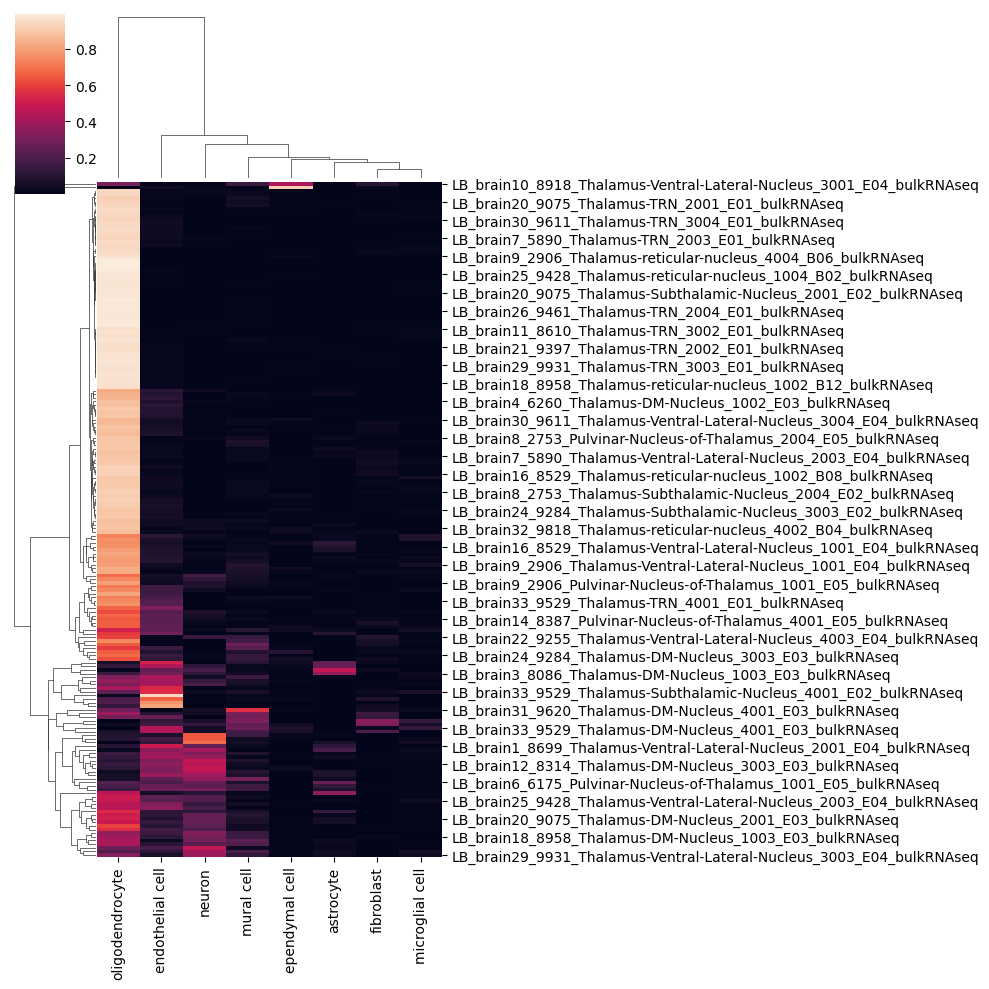

In [508]:
import seaborn as sns

sns.clustermap(
    pd.DataFrame(
        mixture_model(
            torch.tensor(
                bulk_scanvi[
                    :,
                    pbulk.var.highly_variable
                ].X
            ).float()
        ).detach().numpy(),
        index=bulk_scanvi.obs.index,
        columns=pbulk.obs.columns,
    )
)

IndexError: index 8 is out of bounds for axis 1 with size 8

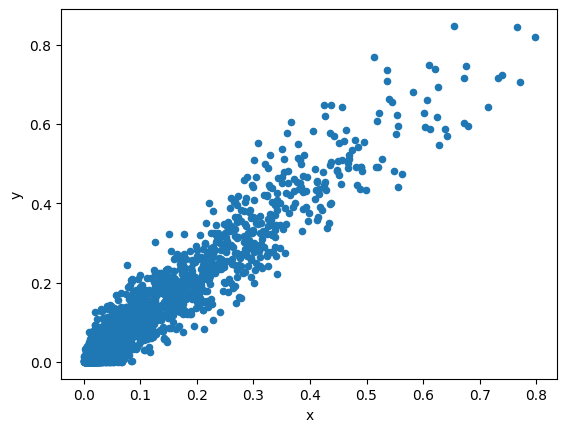

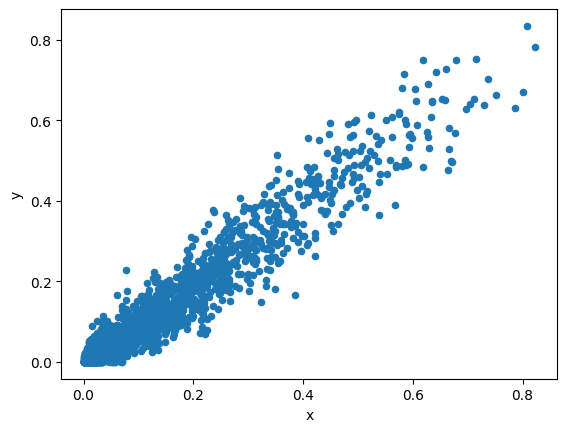

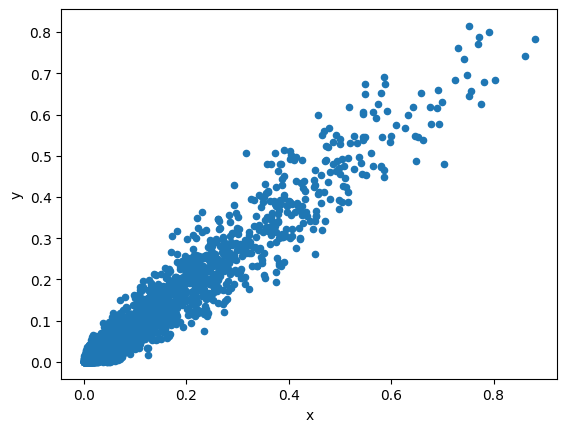

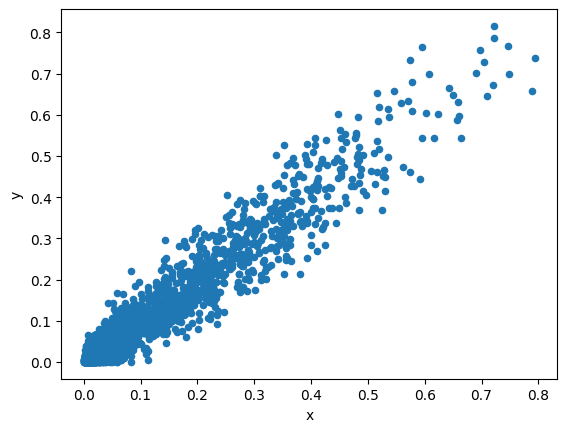

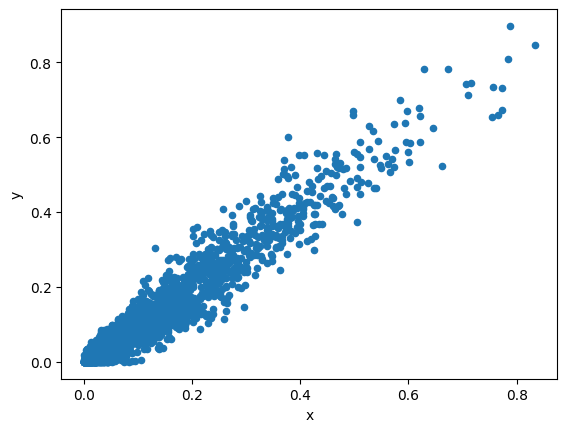

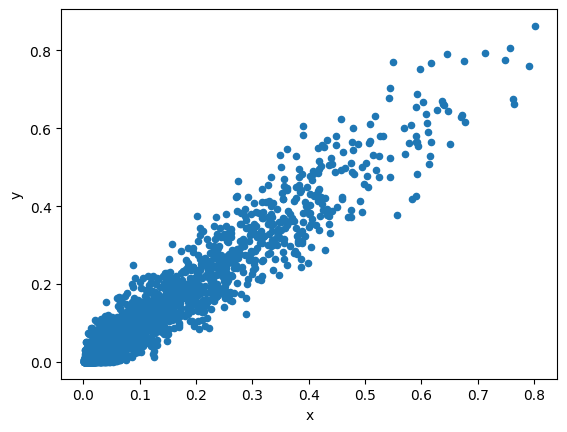

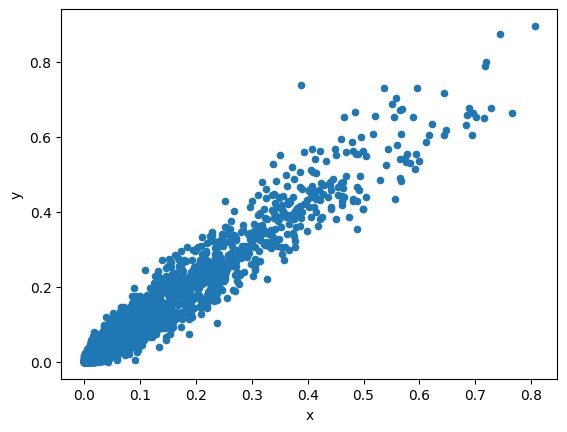

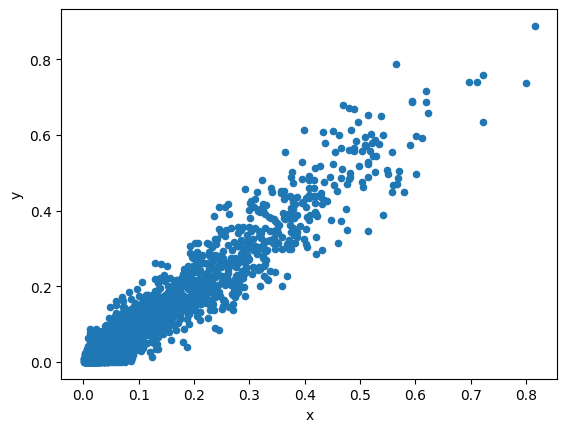

In [511]:
for i in range(X_test.shape[1]):
    pd.DataFrame({
        "x": mixture_model(X_test).detach().cpu().numpy()[:, i],
        "y": y_test.detach().cpu().numpy()[:, i]
    }).plot.scatter("x", "y")

# Training Dirichlet Model

In [64]:
mixture_weights = mixture_model(X)
mixture_weights = mixture_weights.detach()

In [ ]:
dirichlet_model = models.MixtureToDirichlet(num_components=8, num_features=X.shape[1]).to("cuda")

In [75]:
import numpy as np
counts = torch.tensor(np.stack([pbulk.layers[layer] for layer in pbulk.layers if layer in pbulk.obs.columns])).permute(1, 0, 2)

In [253]:
from torch import nn

class MixtureToDirichlet(nn.Module):
    def __init__(self, num_components, num_features, hidden_dim=128):
        super().__init__()
        self.num_components = num_components
        self.num_features = num_features

        # MLP will process concatenated (pi, X)
        self.fc1 = nn.Linear(num_components + num_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_components * num_features)

    def forward(self, pi, X):
        """
        Args:
            pi: [n, C] - mixture weights per sample
            X:  [n, F] - observed total gene expression per sample
        Returns:
            alpha: [n, C, F] - Dirichlet parameters
        """
        x = torch.cat([pi, X], dim=1)        # [n, C + F]
        x = F.relu(self.fc1(x))              # [n, hidden_dim]
        x = self.fc2(x).view(-1, self.num_components, self.num_features)  # [n, C, F]
        alpha = F.softplus(x) + 1e-3         # ensure positivity
        return alpha

    @staticmethod
    def dirichlet_multinomial_loss(alpha, counts):
        """
        Args:
            alpha: [n, C, F] - predicted Dirichlet params
            counts: [n, C, F] - observed counts per component per feature
        Returns:
            scalar - Negative log-likelihood
        """
        n, C, F = counts.shape

        # Flatten over (n, f)
        alpha_flat = alpha.permute(0, 2, 1).reshape(-1, C)   # [n * F, C]
        counts_flat = counts.permute(0, 2, 1).reshape(-1, C) # [n * F, C]
        total_count = counts_flat.sum(dim=1)                # [n * F]

        dist = DirichletMultinomial(total_count=total_count, concentration=alpha_flat)
        return -dist.log_prob(counts_flat).mean()


In [260]:
import torch.nn.functional as F
from pyro.distributions import DirichletMultinomial
from torch.utils.data import TensorDataset, DataLoader

# Normalize expression (shape: [n, F])
expression = utils.scanpy_log_normalize(counts.sum(dim=1)).to("cuda")  # [n, F]

# Create dataset and dataloader
batch_size = pbulk.shape[0]
dataset = TensorDataset(mixture_weights, expression, counts)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = MixtureToDirichlet(num_components=counts.shape[1], num_features=counts.shape[2]).to("cuda")

I tried to train it for 10_000, but it got canceled.

Honestly still outperforms what I was expecting with just a couple hundred, so it's not so bad. 

In [ ]:

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(10_000):
    model.train()
    epoch_loss = 0.0

    for batch_mixture, batch_expr, batch_counts in loader:
        batch_mixture = batch_mixture.to("cuda")  # [b, C]
        batch_expr = batch_expr.to("cuda")        # [b, F]
        batch_counts = batch_counts.to("cuda")    # [b, C, F]

        optimizer.zero_grad()
        alpha_pred = model(batch_mixture, batch_expr)  # [b, C, F]
        loss = model.dirichlet_multinomial_loss(alpha_pred, batch_counts)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(loader)
    print(f"Epoch {epoch} | Loss: {avg_loss:.4f}")


In [263]:
torch.save(model, "../models/dirichlet_expr_model.pt")
dirichlet_model = torch.load("../models/dirichlet_expr_model.pt", weights_only=False)

# Output

In [ ]:
def dirichlet_mle_counts(alpha: torch.Tensor, total_counts: torch.Tensor) -> torch.Tensor:
    """
    Args:
        alpha: [n, C, F] - Dirichlet concentration parameters
        total_counts: [n, F] - observed total counts per feature per sample

    Returns:
        estimated_counts: [n, C, F] - MLE count split per component
    """
    # Dirichlet mean
    alpha_sum = alpha.sum(dim=1, keepdim=True)  # [n, 1, F]
    probs = alpha / alpha_sum  # [n, C, F]

    # Broadcast total counts across components
    estimated_counts = probs * total_counts.unsqueeze(1)  # [n, C, F]
    return estimated_counts

layer_counts = dirichlet_mle_counts(
    dirichlet_model(batch_mixture),
    total_counts=torch.tensor(pbulk.X).to("cuda")
)

In [234]:
for i, layer in enumerate(pbulk.obs.columns):
    pbulk.layers["predicted " + layer] = layer_counts[:, i, :].cpu().detach().numpy()
    pbulk.layers["alpha " + layer] = dirichlet_model(batch_mixture)[:, i, :].cpu().detach().numpy()

<Axes: xlabel='x', ylabel='y'>

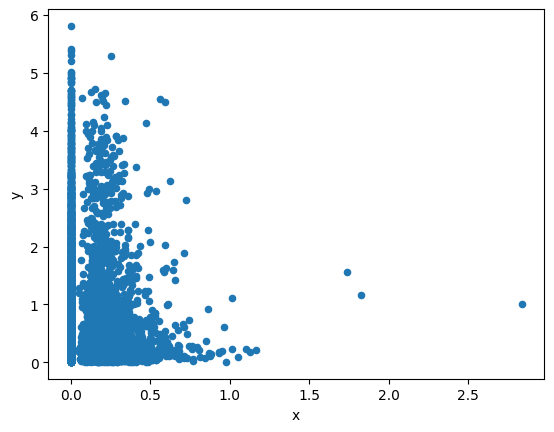

In [265]:
import pandas as pd
pd.DataFrame({
    "x": pbulk.layers["astrocyte"][:, 1],
    "y": pbulk.layers["alpha astrocyte"][:, 1]
}).plot.scatter("x", "y")

# Testing

/home/jhaberbe/Projects/Personal/bulk-deconvolution/.venv/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)


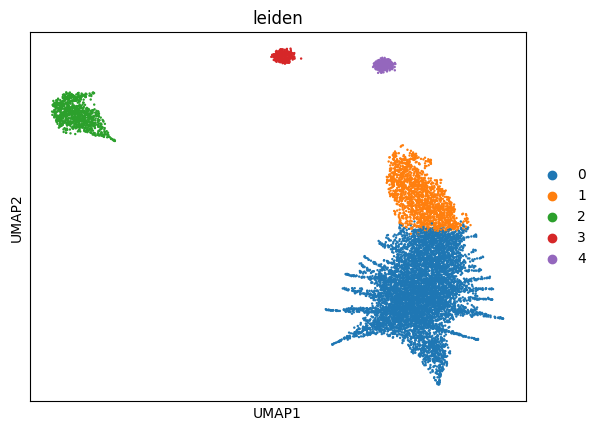

In [276]:
import anndata as ad

testing = ad.AnnData(
    X=pbulk.layers["endothelial cell"]
)
sc.pp.normalize_total(testing)
sc.pp.log1p(testing)
sc.pp.pca(testing)
sc.pp.neighbors(testing)
sc.tl.leiden(testing, resolution=0.1)
sc.tl.umap(testing)
sc.pl.umap(testing, color=["leiden"])

/tmp/ipykernel_1527556/3257457861.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  testing.obs["leiden"] = leiden


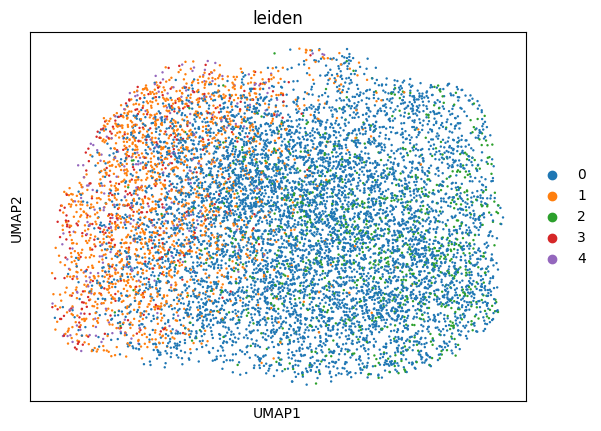

In [278]:
import anndata as ad

leiden = testing.obs["leiden"]
testing = ad.AnnData(
    X=pbulk.layers["predicted endothelial cell"]
)
testing = testing[:, pd.Series(pbulk.layers["alpha endothelial cell"].mean(axis=0)).gt(2)]
testing.obs["leiden"] = leiden
sc.pp.normalize_total(testing)
sc.pp.log1p(testing)
sc.pp.pca(testing)
sc.pp.neighbors(testing)
sc.tl.umap(testing)
sc.pl.umap(testing, color="leiden")

# On unseen data